In [58]:
import matplotlib.pyplot as plt
import shapely.geometry as geom
import numpy as np
import pandas as pd
import geopandas as gpd

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,7)

In [141]:
# https://stackoverflow.com/questions/30740046/calculate-distance-to-nearest-feature-with-geopandas
# https://geohackweek.github.io/vector/04-geopandas-intro/
# https://stackoverflow.com/questions/38882233/geopandas-matplotlib-plot-custom-colors

In [4]:
# for each discretized square (i.e. current position)
# draw cirle centered in the current square
# place 180 (user-definable parameter) evenly spaced points on the circumference
# define a line segmet between current position and each point on the circumference
# find points of intersection of the line segment with: polygons or the walls of the arena
# take the nearest point
# measure the distance between the nearest point point of intersection and the current position
# this should be distance which the sonar and the IR should be measuring (adjusted for noise)

### Parameters

In [174]:
# Define the arena using the upper-case parameters below

# The origin of the arena, (0,0) is in the lower left corner 
# All parametersare in meters 



# Those were given but not correct
# W = 4.25
# H = 3.2

W = 4.25
H = 3.4

RESOLUTION = 0.1 # that is 10 cm
RESOLUTION = 0.4 # that is 80 cm

# Location of the docking station
BASE = [(3.63,1.55), (4.05,1.55), (3.63,1.25), (4.05,1.25)]

HIGHWAYS = {
    "top1" : [],
    "top2" : []  
}

# Each obstacle is represented by its vertices (x,y)

OBSTACLES = {
	"triangle_low_left" : ((0,0), (0.6,0), (0,0.7)),
	"triangle_up_right" : ((3.8,3.4), (4.25,3.4), (4.25,2.9)),
	"triangle_center" : ((1.1,1), (1.9,1), (1.475,1.65)),
	"long_rectangle" : ((1.05,2.45),(3.2,2.45),(3.2,2.29),(1.05,2.29)),
	"low_right_square" : ((3.2,1.05), (4.25,1.05), (4.25,0), (3.2,0))
}

WALLS = {
	"bottom" : ((0,0),(W,0)),
	"right" : ((W,0), (W,H)),
	"top" : ((W,H), (0,H)),
	"left" : ((0,H), (0,0))
}

GROUND = ((0,0),(W,0),(W,H),(0,H),(0,0))


               type                                           geometry
0          obstacle                 POLYGON ((0 0, 0.6 0, 0 0.7, 0 0))
1          obstacle   POLYGON ((3.8 3.4, 4.25 3.4, 4.25 2.9, 3.8 3.4))
2          obstacle        POLYGON ((1.1 1, 1.9 1, 1.475 1.65, 1.1 1))
3          obstacle  POLYGON ((1.05 2.45, 3.2 2.45, 3.2 2.29, 1.05 ...
4          obstacle  POLYGON ((3.2 1.05, 4.25 1.05, 4.25 0, 3.2 0, ...
5              wall                           LINESTRING (0 0, 4.25 0)
6              wall                      LINESTRING (4.25 0, 4.25 3.4)
7              wall                       LINESTRING (4.25 3.4, 0 3.4)
8              wall                            LINESTRING (0 3.4, 0 0)
9  current location                                        POINT (0 0)


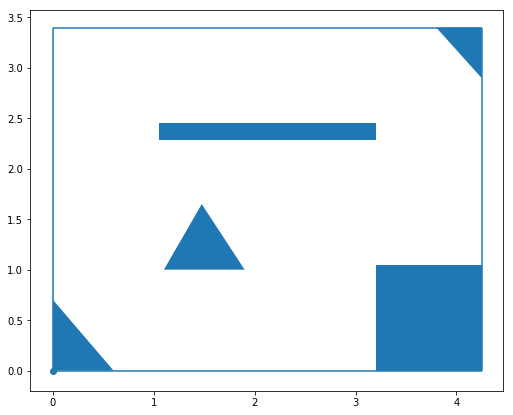

In [175]:
# arena_d Dataframe
# arena_g Geo DataFrame

arena_d = pd.DataFrame(columns=['type', 'geometry'])

# Obstacles
for polygon in OBSTACLES:
    arena_d.loc[len(arena_d)] = ["obstacle", geom.Polygon(OBSTACLES[polygon])]

# Walls
for wall in WALLS:
    arena_d.loc[len(arena_d)] = ["wall", geom.LineString(WALLS[wall])]

arena_d.loc[len(arena_d)] = ["current location", geom.Point(0,0)]
print(arena_d)

arena_g = gpd.GeoDataFrame(arena_d)

arena_g.plot()

In [212]:
# # Draw a circle of radius 6 meters, defined by approx. 180 discrete points
# circle = geom.Point(0,0).buffer(6, resolution=45)
# # print(len(geom.mapping(point)['coordinates'][0]))

# # for each point on the circumference of the circle
# for p in geom.mapping(circle)['coordinates'][0]:
#     geom.LineString(((0,0), p))
    
# scan = geom.LineString(((2,2), (4.014783638153087, 3.458868952864421)))  

# closest = float("inf")
# for obj in arena_g.loc[arena_g['type'].isin(['obstacle', 'wall']), 'geometry']:
#     # find intersections of the laser scan with obstacles and walls
#     intersection =  np.array(scan.intersection(obj))
#     if intersection.shape == (2, 2): # if intersecting a polygon
#         for i in intersection:
#             distance = geom.Point(i).distance(geom.Point(2,2))
#             if distance < closest:
#                 closest = distance
#     elif intersection.shape == (2,): # if intersecting another line
#         distance = geom.Point(intersection).distance(geom.Point(2,2))
#         if distance < closest:
#             closest = distance
# print(closest)
    

# arena_d.loc[len(arena_d)] = ["scan", scan]
# arena_g = gpd.GeoDataFrame(arena_d)
# arena_g.plot()

### Take measurements (in 360 scans)

In [219]:
num_squares = 0

def emptySpace(position):
    """
    Returns true if a given point is NOT ontop obstacle;
    """
    # iterate over obstacles
    for obj in arena_g.loc[arena_g['type'] == 'obstacle', 'geometry']:
        # if square doesn't intersect with an obstacle
        if obj.intersects(position):
            return False
    return True

def nearestObstacles(position, p):
    laser = geom.LineString((position, p))
    
    nearest = float("inf")
    for obj in arena_g.loc[arena_g['type'].isin(['obstacle', 'wall']), 'geometry']:
        # find intersections of the laser line segment with obstacles and walls
        intersection =  np.array(laser.intersection(obj))
        if intersection.shape == (2, 2): # if intersecting a polygon
            for i in intersection:
                distance = geom.Point(i).distance(position)
                if distance < nearest:
                    nearest = distance
        elif intersection.shape == (2,): # if intersecting another line
            distance = geom.Point(intersection).distance(position)
            if distance < nearest:
                nearest = distance
    return nearest
    dist_array.append(nearest)
    
def scan360(position):
    dist_array = list()
    
    # Draw a circle of radius 6 meters, defined by approx. 180 discrete points
    circle = position.buffer(6, resolution=45)
    # Resolution determines in how many wedges we slice the circle
    # print(len(geom.mapping(point)['coordinates'][0]))
    
    # for each point on the circumference of the circle
    # draw a line segment (called laser) from current position to that point
    for p in geom.mapping(circle)['coordinates'][0]:
        dist_array.append(nearestObstacles(position, p))
        
    return dist_array

    
    
# iterate over the arena (represented as discrete squares)
for x in np.arange(0, W, RESOLUTION):
    for y in np.arange(0,H,RESOLUTION):
        position = geom.Point(x,y) # we're here
        if emptySpace(position):   # if position not on a blocked area, e.g. an obstacle
            measurements = scan360(position)

KeyboardInterrupt: 